### Description of compiled ICESat-2 data

The Pandas DataFrame from ``compiled_data.csv`` contains variables, with each line representing 20-m-resolution along-track data from a single granule that has been binned onto the ERA-Interim 0.75 x 0.75° grid (i.e. now with ~80 km resolution or smaller):
* ``laser`` - beam ID: gt1l, gt1r, gt2l, gt2r, gt3l, gt3r (left beams are strong until 2018-12-28; right beams strong thereafter)
* ``lat``, ``lon`` - (average) latitude, longitude
* ``bs_conf`` and ``bs_conf_x2`` - blowing snow confidence flag $\chi$ (originally ``bsnow_conf``): average and sum-of-squares, where $ \chi = \mathrm{backscatter\ signal\ strength} * U_{10} $
    * note that negative error values were included in this average; in the future these should be masked as ``np.NaN``
* ``bs_od`` and ``bs_od_x2`` - blowing snow optical depth within blowing snow layer (originally ``bsnow_od``)
* ``bs_h`` and ``bs_h_x2`` - blowing snow layer height above ground level (originally ``bsnow_h``)
    * note the blowing snow algorithm requires $U_{10}$ > 5 m/s, surface detection, and a contiguous layer (max 500 m thick) with backscatter above some threshold
* ``N`` - total points within the segment bin
* ``n_bsnow`` - out of ``N``, the total points with ``bs_h`` < 10,000 m (i.e. with a blowing snow layer, since the FillValue for ``bs_h`` is ~$10^{38}$)
* ``%_seg`` - fraction of segment with a blowing snow layer ($= $ ``n_bsnow`` / ``N``)
* ``h_li`` - mean ICESat-2 land ice height of the segment (including all points, not just blowing snow detections)
* ``mean_timestamp_s`` - mean time (in seconds since 1980-01-01 00:00:19) of segment
* ``mean_timestamp_yr`` - mean time (in decimal years) of segment

### Description of ERA-Interim fields (copied from ``erai_reanalysis_demonstration.ipynb`` notebook)

The analysis fields include the following variables:
* ``skt`` - Skin temperature (°C)
* ``t2m`` - Temperature at 2 meters (°C)
* ``u10``, ``v10`` - U, V wind components at 10 m (m/s)
* ``si10`` - 10-m wind speed from 'u10' and 'v10' (m/s)
* ``lcc`` - Low cloud cover (fractional coverage, 0 to 1)
* ``tcc`` - Total cloud cover (fractional coverage, 0 to 1)
* ``rsn`` - Snow density in snow layer (kg/m^3)
* ``sd`` - Snow depth in snow layer (m of water equivalent)
* ``sr`` - Climatological aerodynamic land surface roughness length (m)
* ``tsn`` - Temperature of snow layer (K)

The forecast fields contain the following variables:
* ``tp`` - Precipitation rate (m/s)
* ``sf`` - Snowfall rate (m/s)
* ``blh`` - Boundary layer height (m)

In [224]:
from numpy import *
import xarray as xr
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.interpolate as spin
from scipy import stats
import pandas.plotting._converter as pandacnv   # only necessary due to Pandas 0.21.0 bug with Datetime plotting
pandacnv.register()
from datetime import datetime, timedelta
import os
import pickle
import importlib

import erai_tools as et
importlib.reload(et)

erai_SH_analysis = et.load_ecmwf('Data/ERA_Interim_processed/','erai_SH_analysis.nc')
erai_SH_forecast = et.load_ecmwf('Data/ERA_Interim_processed/','erai_SH_forecast.nc')

bs_data = pd.read_csv('Small_data/compiled_data.csv')

In [225]:
# add Datetime index
bs_data['datetime'] = [datetime(1980,1,1,0,0,19) + timedelta(seconds=s) for s in bs_data['mean_timestamp_s']]
print('>> confirm start/end of data: {0} to {1}'.format(min(bs_data['datetime']),max(bs_data['datetime'])))

# add flag for strong beams
bs_data['strong'] = logical_or(logical_and(bs_data['laser'].isin(['gt1l','gt2l','gt3l']),
                                           bs_data['datetime'] < datetime(2018,12,28,1,1,1)),
                               logical_and(bs_data['laser'].isin(['gt1r','gt2r','gt3r']),
                                           bs_data['datetime'] >= datetime(2018,12,29,1,1,1)))
print('>> confirm that fraction of data tagged as from strong beams is about 50%: {0:.04f}'
      .format(sum(bs_data['strong'])/len(bs_data['strong'])))
strong_mask = bs_data['strong']
strong_and_valid_mask = logical_and(bs_data['strong'],~isnan(bs_data['bs_h']))

>> confirm start/end of data: 2018-10-10 00:44:09.645472 to 2019-01-17 22:52:41.311334
>> confirm that fraction of data tagged as from strong beams is about 50%: 0.4825


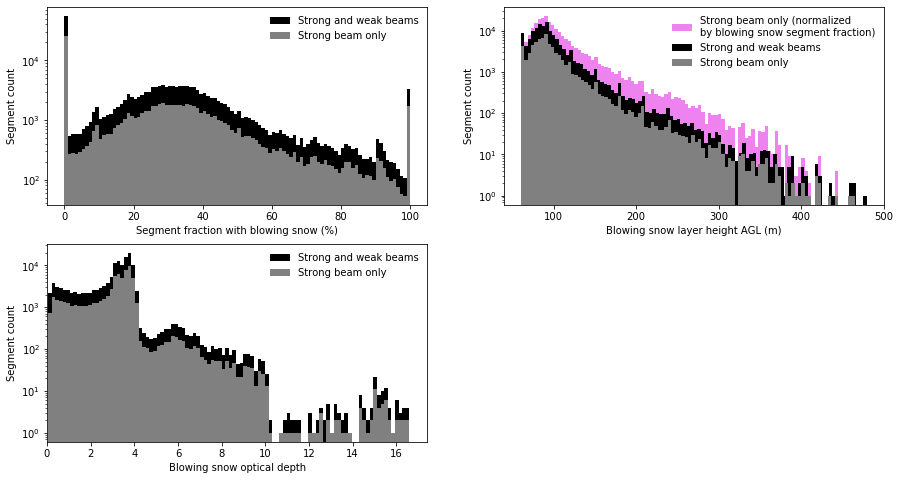

In [160]:
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.hist(bs_data['%_seg'],bins=100,color='k',label='Strong and weak beams');
plt.hist(bs_data['%_seg'][strong_mask],bins=100,color='0.5',label='Strong beam only');
plt.legend(loc='upper right',frameon=False)
plt.yscale('log')
plt.xlabel('Segment fraction with blowing snow (%)');
plt.ylabel('Segment count');

bs_h_orig = bs_data['bs_h'][strong_and_valid_mask].values
seg_orig = bs_data['%_seg'][strong_and_valid_mask].values
bs_h_normalized = []
for idx in range(0,len(bs_h_orig)):
    bs_h_normalized.extend(tile(bs_h_orig[idx],int(seg_orig[idx]/10)))

plt.subplot(2,2,2)
plt.hist(bs_h_normalized,bins=100,color='violet',
         label='Strong beam only (normalized\nby blowing snow segment fraction)')
plt.hist(bs_data['bs_h'],bins=100,color='k',label='Strong and weak beams');
plt.hist(bs_data['bs_h'][strong_mask],bins=100,color='0.5',label='Strong beam only');
plt.legend(loc='upper right',frameon=False)
plt.yscale('log')
plt.xlabel('Blowing snow layer height AGL (m)');
plt.ylabel('Segment count');

plt.subplot(2,2,3)
plt.hist(bs_data['bs_od'],bins=100,color='k',label='Strong and weak beams');
plt.hist(bs_data['bs_od'][strong_mask],bins=100,color='0.5',label='Strong beam only');
plt.legend(loc='upper right',frameon=False)
plt.xlim([0,None])
plt.yscale('log')
plt.xlabel('Blowing snow optical depth');
plt.ylabel('Segment count');

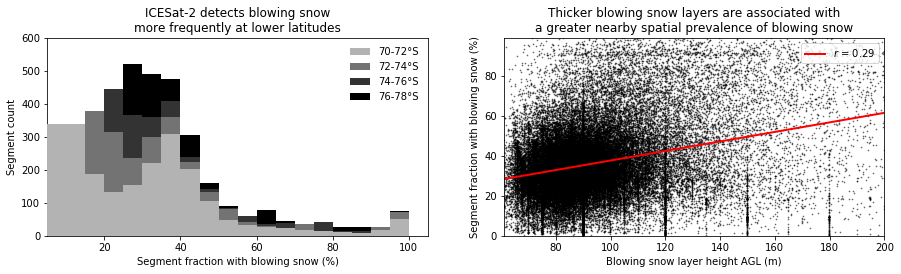

In [137]:
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.hist(bs_data['%_seg'][logical_and(bs_data['lat'] < -70,bs_data['lat'] > -72)],
         color='0.7',bins=20,label='70-72°S',zorder=4);
plt.hist(bs_data['%_seg'][logical_and(bs_data['lat'] < -72,bs_data['lat'] > -74)],
         color='0.45',bins=20,label='72-74°S',zorder=3);
plt.hist(bs_data['%_seg'][logical_and(bs_data['lat'] < -74,bs_data['lat'] > -76)],
         color='0.2',bins=20,label='74-76°S',zorder=2);
plt.hist(bs_data['%_seg'][logical_and(bs_data['lat'] < -76,bs_data['lat'] > -78)],
         color='k',bins=20,label='76-78°S',zorder=1);
plt.legend(loc='upper right',frameon=False)
plt.xlim([5,None]);
plt.ylim([0,600]);
plt.xlabel('Segment fraction with blowing snow (%)');
plt.ylabel('Segment count');
plt.title('ICESat-2 detects blowing snow\nmore frequently at lower latitudes');

xlim = array([61,200])
ylim = array([0,99])
bs_h_mask = logical_and(strong_and_valid_mask,logical_and(bs_data['bs_h'] < xlim[1],bs_data['bs_h'] > xlim[0]))
seg_mask = logical_and(strong_and_valid_mask,logical_and(bs_data['%_seg'] < ylim[1],bs_data['bs_h'] > ylim[0]))
final_mask = logical_and(bs_h_mask,seg_mask)
m, b, r, p, _ = stats.linregress(bs_data['bs_h'][final_mask].values,bs_data['%_seg'][final_mask].values)

plt.subplot(2,2,2)
plt.scatter(bs_data['bs_h'][strong_mask],bs_data['%_seg'][strong_mask],s=0.5,c='k',alpha=0.5);
plt.plot(xlim,b+m*xlim,c='r',lw=2,label=r'$r$ = {0:.02f}'.format(r))
plt.legend(loc='upper right')
plt.xlim(xlim);
plt.ylim(ylim);
plt.xlabel('Blowing snow layer height AGL (m)');
plt.ylabel('Segment fraction with blowing snow (%)');
plt.title('Thicker blowing snow layers are associated with\na greater nearby spatial prevalence of blowing snow');

In [230]:
# note that <<strong_and_valid_mask>> will be required to match indices
t2m_dict = et.along_track(bs_data['lat'][strong_and_valid_mask].values,
                          bs_data['lon'][strong_and_valid_mask].values,
                          bs_data['datetime'][strong_and_valid_mask].values,
                          erai_SH_analysis,'t2m',prior_days=2.0,use_parallel=True)
pickle.dump(t2m_dict,open('/Users/Ethan/Documents/Research/Git/Snowblower/Data/along_track_t2m_dict.pickle','wb'))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 798 tasks      | elapsed:    3.8s
[Parallel(n_jobs=3)]: Done 2058 tasks      | elapsed:    9.3s
[Parallel(n_jobs=3)]: Done 3822 tasks      | elapsed:   18.2s
[Parallel(n_jobs=3)]: Done 6090 tasks      | elapsed:   30.1s
[Parallel(n_jobs=3)]: Done 8862 tasks      | elapsed:   45.7s
[Parallel(n_jobs=3)]: Done 12138 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 15918 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 20202 tasks      | elapsed:  1.7min
[Parallel(n_jobs=3)]: Done 24990 tasks      | elapsed:  2.1min
[Parallel(n_jobs=3)]: Done 30282 tasks      | elapsed:  2.6min
[Parallel(n_jobs=3)]: Done 36078 tasks      | elapsed:  3.0min
[Parallel(n_jobs=3)]: Done 42378 tasks      | elapsed:  3.5min
[Parallel(n_jobs=3)]: Done 49182 tasks      | elapsed:  4.1min
[Parallel(n_jobs=3)]: Done 56490 tasks      | elaps

In [231]:
t2m_dict = pickle.load(open('/Users/Ethan/Documents/Research/Git/Snowblower/Data/along_track_t2m_dict.pickle','rb'))

In [240]:
# subsampling
ss = 1

U10_dict = et.along_track(bs_data['lat'][strong_and_valid_mask].values[::ss],
                          bs_data['lon'][strong_and_valid_mask].values[::ss],
                          bs_data['datetime'][strong_and_valid_mask].values[::ss],
                          erai_SH_analysis,'si10',prior_days=2.0,use_parallel=True)
pickle.dump(U10_dict,open('/Users/Ethan/Documents/Research/Git/Snowblower/Data/along_track_U10_dict.pickle','wb'))

# U10_matchup = array([erai_SH_analysis.sel(time=pd.to_datetime(bs_data['datetime'][strong_and_valid_mask].values[idx]),
#                                           lons=bs_data['lon'][strong_and_valid_mask].values[idx],
#                                           lats=bs_data['lat'][strong_and_valid_mask].values[idx],
#                                           method='nearest')['si10'] 
#                      for idx in range(len(bs_data['datetime'][strong_and_valid_mask]))])

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    3.8s
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:    6.0s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:    9.5s
[Parallel(n_jobs=3)]: Done 401 tasks      | elapsed:   16.5s
[Parallel(n_jobs=3)]: Done 725 tasks      | elapsed:   26.1s
[Parallel(n_jobs=3)]: Done 1121 tasks      | elapsed:   37.5s
[Parallel(n_jobs=3)]: Done 1589 tasks      | elapsed:   52.1s
[Parallel(n_jobs=3)]: Done 2129 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 2741 tasks      | elapsed:  1.6min
[Parallel(n_jobs=3)]: Done 3425 tasks      | elapsed:  2.0min
[Parallel(n_jobs=3)]: Done 4181 tasks      | elapsed:  2.5min
[Parallel(n_jobs=3)]: Done 5009 tasks      | elapsed:  2.9min
[Parallel(n_jobs=3)]: Done 5909 tasks      | elapsed:  3.4min
[Parallel(n_jobs=3)]: Done 6881 tasks      | elapsed:  3.9min
[Parallel(n_jobs=3)]: Done 8683 tasks      | elapsed:  4.7min


In [238]:
U10_dict = pickle.load(open('/Users/Ethan/Documents/Research/Git/Snowblower/Data/along_track_U10_dict.pickle','rb'))

In [239]:
sf_dict = et.along_track(bs_data['lat'][strong_and_valid_mask].values,
                         bs_data['lon'][strong_and_valid_mask].values,
                         bs_data['datetime'][strong_and_valid_mask].values,
                         erai_SH_forecast,'sf',prior_days=2.0,use_parallel=True)
pickle.dump(sf_dict,open('/Users/Ethan/Documents/Research/Git/Snowblower/Data/along_track_sf_dict.pickle','wb'))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 726 tasks      | elapsed:    3.1s
[Parallel(n_jobs=3)]: Done 2814 tasks      | elapsed:   10.6s
[Parallel(n_jobs=3)]: Done 5838 tasks      | elapsed:   22.8s
[Parallel(n_jobs=3)]: Done 9726 tasks      | elapsed:   38.3s
[Parallel(n_jobs=3)]: Done 14478 tasks      | elapsed:   57.1s
[Parallel(n_jobs=3)]: Done 20094 tasks      | elapsed:  1.3min
[Parallel(n_jobs=3)]: Done 26574 tasks      | elapsed:  1.7min
[Parallel(n_jobs=3)]: Done 33918 tasks      | elapsed:  2.2min
[Parallel(n_jobs=3)]: Done 42126 tasks      | elapsed:  2.7min
[Parallel(n_jobs=3)]: Done 51198 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done 61134 tasks      | elapsed:  3.9min
[Parallel(n_jobs=3)]: Done 67988 out of 67988 | elapsed:  4.3min finished


In [241]:
sf_dict = pickle.load(open('/Users/Ethan/Documents/Research/Git/Snowblower/Data/along_track_sf_dict.pickle','rb'))

In [242]:
# subsampling
ss = 1

tcc_dict = et.along_track(bs_data['lat'][strong_and_valid_mask].values[::ss],
                          bs_data['lon'][strong_and_valid_mask].values[::ss],
                          bs_data['datetime'][strong_and_valid_mask].values[::ss],
                          erai_SH_analysis,'tcc',prior_days=2.0,use_parallel=True)
pickle.dump(tcc_dict,open('/Users/Ethan/Documents/Research/Git/Snowblower/Data/along_track_tcc_dict.pickle','wb'))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=3)]: Done 466 tasks      | elapsed:    6.2s
[Parallel(n_jobs=3)]: Done 1726 tasks      | elapsed:   11.8s
[Parallel(n_jobs=3)]: Done 3490 tasks      | elapsed:   20.7s
[Parallel(n_jobs=3)]: Done 5758 tasks      | elapsed:   31.9s
[Parallel(n_jobs=3)]: Done 8530 tasks      | elapsed:   45.4s
[Parallel(n_jobs=3)]: Done 11806 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 15586 tasks      | elapsed:  1.3min
[Parallel(n_jobs=3)]: Done 19870 tasks      | elapsed:  1.6min
[Parallel(n_jobs=3)]: Done 24658 tasks      | elapsed:  2.0min
[Parallel(n_jobs=3)]: Done 29950 tasks      | elapsed:  2.4min
[Parallel(n_jobs=3)]: Done 35746 tasks      | elapsed:  2.8min
[Parallel(n_jobs=3)]: Done 42046 tasks      | elapsed:  3.3min
[Parallel(n_jobs=3)]: Done 48850 tasks      | elapsed:  3.8min
[Parallel(n_jobs=3)]: Done 56158 tasks      | elaps

In [ ]:
tcc_dict = pickle.load(open('/Users/Ethan/Documents/Research/Git/Snowblower/Data/along_track_tcc_dict.pickle','rb'))